In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

np.set_printoptions(suppress=True)

# 整体大盘相关性

In [2]:
all_data = pd.read_csv('./32029117-自适应难度分析-编辑框5-查询4.csv', encoding = 'gb18030')
all_data.head()

,kp_id,question_cnt,correct_cnt,mastery_degree
0,6811316203278139661,308,202,75.123377
1,6838454156403949831,495,476,88.539394
2,6811363145387409677,307,245,86.469055
3,6811316312472584456,865,785,83.359538
4,6811316341430026503,465,412,82.453763


In [9]:
data = all_data

Text(0, 0.5, 'Correct Rate for Level Test')

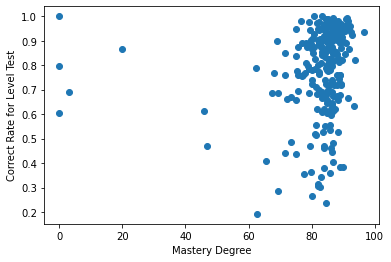

In [10]:
plt.plot(data.mastery_degree, data.correct_cnt / data.question_cnt, 'o')
plt.xlabel('Mastery Degree')
plt.ylabel('Correct Rate for Level Test')

In [6]:
np.corrcoef(data.mastery_degree, data.correct_cnt / data.question_cnt)

array([[1.        , 0.15551308],
       [0.15551308, 1.        ]])

Text(0, 0.5, 'Correct Rate for Level Test')

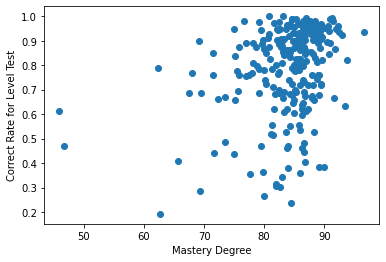

In [11]:
data = all_data[all_data.mastery_degree >= 40]
plt.plot(data.mastery_degree, data.correct_cnt / data.question_cnt, 'o')
plt.xlabel('Mastery Degree')
plt.ylabel('Correct Rate for Level Test')

In [13]:
np.corrcoef(data.mastery_degree, data.correct_cnt / data.question_cnt)

array([[1.        , 0.31734019],
       [0.31734019, 1.        ]])

# 分知识点看相关性

In [28]:
kp_data = pd.read_csv('./32072960-自适应难度分析-掌握度与进阶测试正确率-查询7.csv', encoding = 'gb18030')
kp_data.loc[(kp_data['mastery_degree'] >= 80), 'mastery_degree_gt80'] = 1
kp_data.loc[(kp_data['mastery_degree'] < 80), 'mastery_degree_gt80'] = 0

kp_data.head()

,point_name,kp_id,user_id,create_time,question_cnt,correct_cnt,mastery_degree,correct_yn,rk,mastery_degree_gt80
0,in + 年份/月份/季节,6824460575624429837,3676377582404424,1601383124,1,1,59,1,1,0.0
1,in + 年份/月份/季节,6824460575624429837,3588417885309544,1601104974,1,0,73,0,1,0.0
2,in + 年份/月份/季节,6824460575624429837,3254168965363341,1601709254,1,1,75,1,1,0.0
3,student,6862565679971729671,2884747293891454,1604761042,1,0,0,0,1,0.0
4,表达不确定,6838453935078965517,3359714421262440,1600946497,1,1,90,1,1,1.0


In [29]:
kp_list = kp_data.kp_id.unique()
kp_summary = pd.DataFrame(columns = ["kp_id", "kp_name","correct_user_cnt", "wrong_user_cnt", "master_degree_diff", "min_sample", "p_value", "mastery_degree_gt80_perc"])

In [30]:
for i in range(0,len(kp_list)):
    kp_id = kp_list[i]
    kp_data_s = kp_data[kp_data.kp_id == kp_id]
    kp_correct = kp_data_s[kp_data_s.correct_yn == 1].mastery_degree
    kp_wrong = kp_data_s[kp_data_s.correct_yn == 0].mastery_degree
    
    kp_name = kp_data_s.point_name.unique()
    correct_user_cnt = len(kp_correct)
    wrong_user_cnt = len(kp_wrong)
    md = kp_correct.mean() - kp_wrong.mean()
    min_sample = min(len(kp_correct), len(kp_wrong))
    p_value = stats.ttest_ind(kp_correct, kp_wrong, equal_var = False).pvalue
    md_gt_80 = sum(kp_data_s.mastery_degree_gt80)/len(kp_data_s)
    kp_summary = kp_summary.append({'kp_id': kp_id, 'kp_name': kp_name, 'correct_user_cnt': correct_user_cnt, 'wrong_user_cnt': wrong_user_cnt, 'master_degree_diff': md, 'min_sample' : min_sample, 'p_value': p_value, 'mastery_degree_gt80_perc' : md_gt_80}, ignore_index = True)


/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [31]:
kp_summary.loc[(kp_summary['min_sample'] >= 30), 'enough_sample_yn'] = 'Y'
kp_summary.loc[(kp_summary['min_sample'] < 30), 'enough_sample_yn'] = 'N'

kp_summary.loc[(kp_summary['p_value'] <= 0.05), 'sig_diff_yn'] = 'Y'
kp_summary.loc[(kp_summary['p_value'] > 0.05), 'sig_diff_yn'] = 'N'

kp_summary.loc[(kp_summary['master_degree_diff'] > 0), 'greater_md'] = 'Y'
kp_summary.loc[(kp_summary['master_degree_diff'] <= 0), 'greater_md'] = 'N'


In [38]:
kp_summary.loc[(kp_summary['mastery_degree_gt80_perc'] >= 0.9), 'mastery_degree_gt80_perc_flag'] = 'High_gt_90p'
kp_summary.loc[(kp_summary['mastery_degree_gt80_perc'] < 0.9) & (kp_summary['mastery_degree_gt80_perc'] > 0.7), 'mastery_degree_gt80_perc_flag'] = 'Mid_70p_90p'

In [39]:
kp_summary.groupby(['mastery_degree_gt80_perc_flag']).size()

mastery_degree_gt80_perc_flag
High    137
Low     125
dtype: int64

In [40]:
kp_summary.groupby(['enough_sample_yn', 'sig_diff_yn', 'mastery_degree_gt80_perc_flag']).size()

enough_sample_yn  sig_diff_yn  mastery_degree_gt80_perc_flag
N                 N            High                             37
                               Low                              19
                  Y            High                             11
                               Low                              16
Y                 N            High                             45
                               Low                              40
                  Y            High                             42
                               Low                              46
dtype: int64

In [184]:
kp_summary['kp_id2'] = kp_summary['kp_id'].apply(str) + '\t'

In [34]:
kp_summary.sort_values(by=['mastery_degree_gt80_perc'])

,kp_id,kp_name,correct_user_cnt,wrong_user_cnt,master_degree_diff,min_sample,p_value,mastery_degree_gt80_perc,enough_sample_yn,sig_diff_yn,greater_md
253,6811316347327234312,[supermarket],164,53,-0.229291,53,0.877189,0.000000,Y,N,N
3,6811316326297010445,[seventeen],359,75,0.000000,75,NaN,0.000000,Y,NaN,N
69,6811316286883168519,[nan],63,33,0.000000,33,NaN,0.000000,Y,NaN,N
33,6811362964549959949,[不定冠词],6,0,NaN,0,NaN,0.000000,N,NaN,NaN
10,6811363101888299272,[寻求帮助],319,42,-2.546499,42,0.670996,0.155125,Y,N,N
...,...,...,...,...,...,...,...,...,...,...,...
22,6853811145828991245,"[If you were in my shoes, ...]",101,59,5.448397,59,0.098987,0.943750,Y,N,Y
217,6811316313860899079,[kiss],476,78,-3.587266,78,0.028129,0.944043,Y,Y,N
120,6850723940617191693,[settle down],146,12,-1.795662,12,0.509942,0.949367,N,N,N
152,6811316354382037255,[fish],117,5,17.456410,5,0.119503,0.975410,N,N,Y


In [170]:
kp_summary.to_csv(r'./mastery_dist.csv', encoding='utf_8_sig')

In [164]:
kp_summary.dtypes

kp_id                object
kp_name              object
correct_user_cnt     object
wrong_user_cnt       object
min_sample           object
p_value             float64
enough_sample_yn     object
sig_diff_yn          object
kp_id2               object
dtype: object

# 分不同维度 - 难度，掌握度分布，是否是锚点题

In [2]:
kp_data = pd.read_csv('/home/tiger/archived-data/aeolus-data/20201122/20/32742451-自适应难度分析-编辑框6-查询9.csv', encoding = 'gb18030')
kp_data.loc[(kp_data['mastery_degree'] >= 80), 'mastery_degree_gt80'] = 1
kp_data.loc[(kp_data['mastery_degree'] < 80), 'mastery_degree_gt80'] = 0

kp_data.head()

,point_name,kp_id,user_id,create_time,question_cnt,correct_cnt,mastery_degree,correct_yn,rk,exercise_id,ac_exe_yn,difficulty,mastery_degree_gt80
0,football,6811316253047718157,53881777650,1598755580,1,1,96,1,1,NaN,0,NaN,1.0
1,football,6811316253047718157,87308878686,1597466901,1,1,96,1,1,NaN,0,NaN,1.0
2,football,6811316253047718157,102849189067,1594352716,1,1,88,1,1,NaN,0,NaN,1.0
3,football,6811316253047718157,103585847816,1594380655,1,1,93,1,1,NaN,0,NaN,1.0
4,football,6811316253047718157,104401002059,1600219658,1,1,81,1,1,NaN,0,NaN,1.0


In [4]:
kp_list = kp_data.kp_id.unique()
kp_summary = pd.DataFrame(columns = ["kp_id", "kp_name", "exercise_id", "ac_exe_yn", "difficulty", "correct_user_cnt", "wrong_user_cnt", "master_degree_diff", "min_sample", "p_value", "mastery_degree_gt80_perc", "mastery_degree_gt80_perc_range"])

for i in range(0,len(kp_list)):
    kp_id = kp_list[i]
    kp_data_s = kp_data[kp_data.kp_id == kp_id]
    kp_correct = kp_data_s[kp_data_s.correct_yn == 1].mastery_degree
    kp_wrong = kp_data_s[kp_data_s.correct_yn == 0].mastery_degree
    
    kp_name = kp_data_s.point_name.unique()
    exercise_id = min(kp_data_s.exercise_id.unique())
    ac_exe_yn = max(kp_data_s.ac_exe_yn.unique())
    difficulty = max(kp_data_s.difficulty.unique())
    correct_user_cnt = len(kp_correct)
    wrong_user_cnt = len(kp_wrong)
    md = kp_correct.mean() - kp_wrong.mean()
    min_sample = min(len(kp_correct), len(kp_wrong))
    p_value = stats.ttest_ind(kp_correct, kp_wrong, equal_var = False).pvalue
    md_gt_80 = sum(kp_data_s.mastery_degree_gt80)/len(kp_data_s)
    md_gt_80_range = "L" if md_gt_80 < 0.7 else "H" if md_gt_80>0.9 else "M"
    kp_summary = kp_summary.append({'kp_id': kp_id, 'kp_name': kp_name, 'exercise_id': exercise_id, 'ac_exe_yn':ac_exe_yn, 'difficulty':difficulty, 'correct_user_cnt': correct_user_cnt, 'wrong_user_cnt': wrong_user_cnt, 'master_degree_diff': md, 'min_sample' : min_sample, 'p_value': p_value, 'mastery_degree_gt80_perc' : md_gt_80 ,'mastery_degree_gt80_perc_range' : md_gt_80_range}, ignore_index = True)

kp_summary.loc[(kp_summary['min_sample'] >= 30), 'enough_sample_yn'] = 'Y'
kp_summary.loc[(kp_summary['min_sample'] < 30), 'enough_sample_yn'] = 'N'

kp_summary.loc[(kp_summary['p_value'] <= 0.05), 'sig_diff_yn'] = 'Y'
kp_summary.loc[(kp_summary['p_value'] > 0.05), 'sig_diff_yn'] = 'N'

kp_summary.loc[(kp_summary['master_degree_diff'] > 0), 'greater_md'] = 'Y'
kp_summary.loc[(kp_summary['master_degree_diff'] <= 0), 'greater_md'] = 'N'

kp_summary.groupby(['enough_sample_yn', 'sig_diff_yn', 'greater_md']).size()

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


enough_sample_yn  sig_diff_yn  greater_md
N                 N            N             14
                               Y             42
                  Y            N              7
                               Y             20
Y                 N            N             13
                               Y             71
                  Y            N              2
                               Y             87
dtype: int64

In [5]:
kp_summary.head()

,kp_id,kp_name,exercise_id,ac_exe_yn,difficulty,correct_user_cnt,wrong_user_cnt,master_degree_diff,min_sample,p_value,mastery_degree_gt80_perc,mastery_degree_gt80_perc_range,enough_sample_yn,sig_diff_yn,greater_md
0,6811316253047718157,[football],NaN,0,NaN,204,12,5.887255,12,0.235596,0.935185,H,N,N,Y
1,6811316299864490247,[double room],79115.0,0,50.0,285,50,1.949825,50,0.534609,0.907463,H,Y,N,Y
2,6811316303370977550,[seldom],NaN,0,NaN,196,17,12.510804,17,0.006866,0.779343,M,N,Y,Y
3,6811316330654908680,[start a business],88263.0,0,50.0,231,174,1.319525,174,0.516774,0.898765,M,Y,N,Y
4,6811316349374087431,[pharmacy],79113.0,0,30.0,421,26,1.346611,26,0.751771,0.894855,M,N,N,Y


In [7]:
kp_summary.groupby(['enough_sample_yn', 'sig_diff_yn', 'mastery_degree_gt80_perc_range']).size()

enough_sample_yn  sig_diff_yn  mastery_degree_gt80_perc_range
N                 N            H                                 17
                               L                                  6
                               M                                 33
                  Y            H                                  8
                               L                                  3
                               M                                 16
Y                 N            H                                 22
                               L                                 11
                               M                                 51
                  Y            H                                  7
                               L                                 12
                               M                                 70
dtype: int64

In [8]:
kp_summary.groupby(['enough_sample_yn', 'sig_diff_yn', 'difficulty']).size()

enough_sample_yn  sig_diff_yn  difficulty
N                 N            10.0           8
                               20.0          22
                               30.0           6
                               50.0           2
                  Y            10.0           2
                               20.0           3
                               30.0           3
                               40.0           2
Y                 N            10.0           7
                               20.0          45
                               30.0          12
                               40.0           3
                               50.0           9
                  Y            10.0           5
                               20.0          38
                               30.0          12
                               40.0           7
                               50.0          12
dtype: int64

In [76]:
kp_summary.groupby(['enough_sample_yn', 'ac_exe_yn', 'sig_diff_yn']).size()

enough_sample_yn  ac_exe_yn  sig_diff_yn
N                 0          N              54
                             Y              26
                  1          N               2
                             Y               1
Y                 0          N              75
                             Y              81
                  1          N               9
                             Y               8
dtype: int64

In [77]:
kp_summary.sort_values(by=['mastery_degree_gt80_perc'])

,kp_id,kp_name,ac_exe_yn,difficulty,correct_user_cnt,wrong_user_cnt,master_degree_diff,min_sample,p_value,mastery_degree_gt80_perc,enough_sample_yn,sig_diff_yn,greater_md
0,6811316253047718157,[football],0,NaN,204,12,5.887255,12,0.235596,H,N,N,Y
147,6811363154321211662,[点餐],0,30.0,679,264,1.572555,264,0.255532,H,Y,N,Y
148,6839950976565150000,[set],0,20.0,596,26,0.239804,26,0.930430,H,N,N,Y
150,6845216941410386183,[I'm curious whether...],0,20.0,287,327,3.363904,287,0.047527,H,Y,Y,Y
151,6846165669919080711,[I wasn't expecting...],0,20.0,255,367,2.617396,255,0.131797,H,Y,N,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,6845207594047439118,[hiking],0,10.0,427,13,-4.015673,13,0.085240,M,N,N,N
70,6811363134025023751,[寻求酒店服务的问答],0,NaN,198,22,16.297980,22,0.025141,M,N,Y,Y
23,6849649268735656205,[regret (not) doing sth],0,50.0,214,51,11.499175,51,0.017760,M,Y,Y,Y
36,6811316321175732494,[trousers],0,20.0,452,276,4.314608,276,0.011737,M,Y,Y,Y


In [10]:
kp_summary['kp_id2'] = kp_summary['kp_id'].apply(str) + '\t'
kp_summary.to_csv(r'./mastery_dist.csv', encoding='utf_8_sig')